Análisis del DataFrame obtenido mediante YahooFinance. 
Objetivo: Identificar las variables más propensas a influir en el valor de la acción.

In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [51]:
ticker = yf.Ticker("AAPL")
info = ticker.info
 
data = yf.download("AAPL", start='2015-07-13', end='2023-10-01')
df = pd.DataFrame(data)
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df.dropna(subset=['SMA_10'], inplace=True)
df.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [26]:
df[.tail()]

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_10
2056,2023-09-25,243.380005,247.100006,238.309998,246.990005,246.990005,104636600,263.115002
2057,2023-09-26,242.979996,249.550003,241.660004,244.119995,244.119995,101993600,260.779001
2058,2023-09-27,244.259995,245.330002,234.580002,240.500000,240.500000,136597200,257.699002
2059,2023-09-28,240.020004,247.550003,238.649994,246.380005,246.380005,117058900,254.733002
2060,2023-09-29,250.000000,254.770004,246.350006,250.220001,250.220001,128346200,252.316000


In [ ]:
# Extraemos los datos de la media movil hasta el 2022-09-31 para el entrenamiento, y del 2022-10-01 en adelante para la validación
train_set = df[df['Date'] <= '2022-09-30']
validate_set = df[df['Date'] >= '2022-10-01']
# Eliminamos las columnas innecesarias
train_set.drop(columns=["Open", "High", "Low", "Close", "Adj Close", "Volume"], inplace=True)
validate_set.drop(columns=["Open", "High", "Low", "Close", "Adj Close", "Volume"], inplace=True)

print(train_set)
print(validate_set)

In [53]:
# Establecer la columna "Date" como índice
train_set.set_index('Date', inplace=True)
validate_set.set_index('Date', inplace=True)

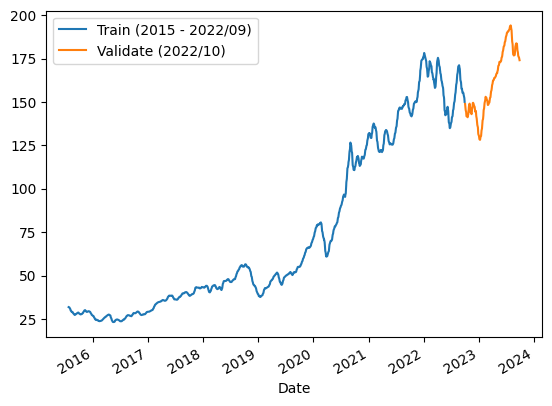

In [54]:
# Gráfico para observar los datos de entrenamiento y validación.
train_set["SMA_10"].plot(legend=True)
validate_set["SMA_10"].plot(legend=True)
plt.legend(['Train (2015 - 2022/09)', 'Validate (2022/10)'])
plt.show()

In [56]:
# Normalizamos los datos de entrenamiento entre 0-1
sc = MinMaxScaler(feature_range=(0,1))
train_set_normal = sc.fit_transform(train_set)

In [60]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (es el resultado de la predicción a partir de esos "time_step" datos). Se conforma de esta manera el set de entrenamiento.
time_step = 60
x_train = []
y_train = []
m = len(train_set_normal)

for i in range(time_step, m):
    # Datos: 0-time_step; 1-time_step+1; 2-time_step+2; etc.
    x_train.append(train_set_normal[i-time_step:i, 0])

    y_train.append(train_set_normal[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))